In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools

# Part 1

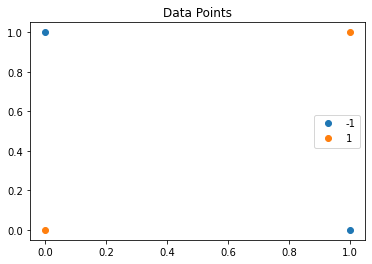

In [2]:
# a) Visualization


samples = pd.DataFrame({
    'x': [1, 0, 1, 0],
    'y': [1, 0, 0, 1],
    'label': [1, 1, -1, -1]
})
for name, group in samples.groupby('label'):
    plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

plt.title('Data Points')
plt.legend()



## b) Network implementation

I chose a two layer fully connected network with no hidden layers. I believe this is the simplest model that can still learn XOR. 

I am using relu as my activation function, and mean squared error loss.


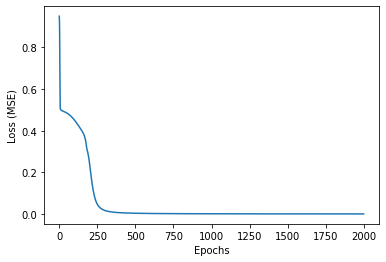

In [3]:



# activation functions
def relu(x):
    return max(0, x)
def d_relu(x):
    return max(0, min(x, 1))    
def tanh(x):
    return math.tanh(x)
def d_tanh(x):
    return 1 - tanh(x) ** 2
def loss(exp_y, act_y):
    return .5 * (exp_y - act_y) ** 2


# model
class Neuron:

    def __init__(self, activation_fn=relu):
        np.random.seed(46)
        self.weights = np.random.rand(3)        
        self.activation_fn = activation_fn

    def pred(self, x, output_pre=False):
        pre_activation = self.weights @ self.concat(x)
        if output_pre:
            return pre_activation
        return self.activation_fn(pre_activation)
    
    def update(self, partials, lr):
        # print(partials)
        self.weights = self.weights - partials * lr
    
    @staticmethod
    def concat(x):
        return np.concatenate((x, [1]))


class NumpyModel:    
    def  __init__(self, lr=.1):
        self.input_layer = [Neuron(), Neuron()]
        self.output_layer = Neuron(activation_fn=tanh)
        self.lr = lr
    
    def pred(self, x, output_pre=False):
        return self.output_layer.pred([self.input_layer[0].pred(x), self.input_layer[1].pred(x)], output_pre=output_pre)
    
    def update(self, exp_y, act_y, x):
        # Update output neuron         
        il = self.input_layer
        partial_l_output_layer = (exp_y - act_y) * d_tanh(self.pred(x, output_pre=True)) * np.array([il[0].pred(x), il[1].pred(x), 1])

        # Update input neuron 
        def update_input_layer(index, neuron):                      
            pre = il[index].pred(x, output_pre=True)
            neuron.update((exp_y - act_y) * d_tanh(self.pred(x, output_pre=True)) * self.output_layer.weights[index] * d_relu(pre) * Neuron.concat(x), self.lr)

        update_input_layer(0, self.input_layer[0])
        update_input_layer(1, self.input_layer[1])      

        self.output_layer.update(partial_l_output_layer, self.lr)


  


# Train with stochastic gradient descent
def sgd(model, train_x, train_y):    
    y_preds = []


    for x, y in zip(train_x, train_y):        
        prediction = model.pred(x)      
        y_preds.append(prediction)
        
    # do the updates    
    for i in range(len(train_x)):
        model.update(y_preds[i], train_y[i], train_x[i])
            

def test(model, test_x, test_y, verbose=False):
    exp_y = [model.pred(x) for x in test_x]  
    if verbose:
        print('TEST X:', test_x)       
        print('TEST Y:', test_y)        
        print('PREDICTED Y:', exp_y)        
    return np.mean(loss(exp_y, test_y))


def train(model, train_x, train_y, epochs=10):
    history = []    
    for epoch in range(epochs):
        loss = test(model, train_x, train_y)
        history.append(loss)
        sgd(model, train_x, train_y)
    return history



train_x = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

train_y = np.array([1, -1, -1, 1])
m = NumpyModel(.1)
history = train(m, train_x, train_y, epochs=2000)


plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')


plt.plot(history)

TEST X: [[0 0]
 [0 1]
 [1 0]
 [1 1]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9601355193357926, -0.9767075409905509, -0.9767431452460829, 0.980999846135015]
LOSS: 0.0003792003256589673


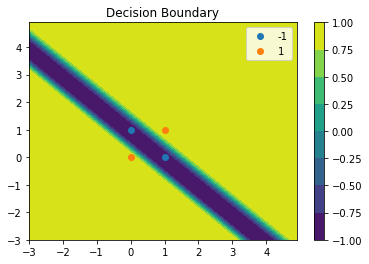

In [4]:
# c) Classification visualization 
# https://towardsdatascience.com/hands-on-guide-to-plotting-a-decision-surface-for-ml-in-python-149710ee2a0e

def model_visualize(m, train_x):    
    print('LOSS:', test(m, train_x, train_y, verbose=True))
    x1_scale = np.arange(-3, 5, 0.1)
    x2_scale = np.arange(-3, 5, 0.1)
    x_grid, y_grid = np.meshgrid(x1_scale, x2_scale)
    x_g, y_g = x_grid.flatten(), y_grid.flatten()
    x_g, y_g = x_g.reshape((len(x_g), 1)), y_g.reshape((len(y_g), 1))
    grid = np.hstack((x_g, y_g))

    preds = []
    for val in grid:
        preds.append(m.pred(val))
    preds = np.array(preds).reshape(80, 80)

    surface = plt.contourf(x_grid, y_grid, preds)

    plt.colorbar(surface)

    samples = pd.DataFrame({
        'x': train_x[:, 0],
        'y': train_x[:, 1],
        'label': [1, -1, -1, 1]
    })    
    for name, group in samples.groupby('label'):
        plt.plot(group['x'], group['y'], marker="o", linestyle="",label=name)

    plt.title('Decision Boundary')
    plt.legend()
    

model_visualize(m, train_x)

TEST X: [[ 0.29243792  0.61559787]
 [ 0.41095013  0.60038582]
 [ 1.20602662 -0.08807831]
 [ 0.96341402  0.71716681]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9340713355012308, -0.9172155624484524, -0.9793807159788167, 0.9676546150593034]
LOSS: 0.0015839038379781788


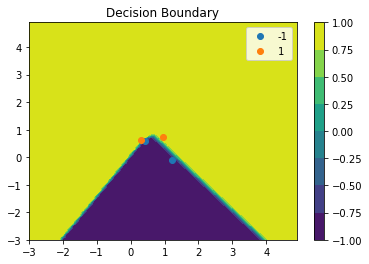

In [5]:
# d) Using random points

def train_and_visualize(sigma):
    np.random.seed(46)
    train_data = train_x + np.random.normal(loc=0.0, scale=sigma, size=train_x.shape)    
    m = NumpyModel(.1)
    train(m, train_data, train_y, epochs=2000)    
    model_visualize(m, train_data)

train_and_visualize(.5)

TEST X: [[ 0.58487584  1.23119574]
 [ 0.82190026  0.20077164]
 [ 1.41205323 -0.17615661]
 [ 0.92682803  0.43433361]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9999999999870766, -0.9504291273320176, -0.9996701874822751, 0.9631941771801079]
LOSS: 0.00047650609835143314


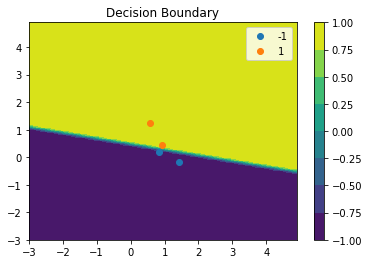

In [6]:
train_and_visualize(1)

TEST X: [[ 1.16975168  2.46239148]
 [ 1.64380053 -0.59845671]
 [ 1.82410646 -0.35231323]
 [ 0.85365606 -0.13133278]]
TEST Y: [ 1 -1 -1  1]
PREDICTED Y: [0.9999999999993696, -0.9885913034676619, -0.9685712726602366, 0.9796081984977247]
LOSS: 0.00019171860340904656


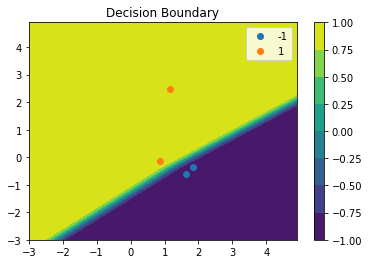

In [7]:
train_and_visualize(2)

# ADD COMMENTS ON THESE RESULTS

# Part 2

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

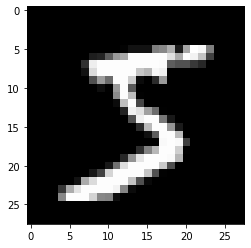

In [9]:
img = train_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(img, cmap='gray')

In [10]:
batch_size = 100
n_iters = 3000
# One iteration occurs after accumulating 100 (batch_size) gradients
# One epoch occurs after going through entire training set

num_epochs = n_iters / (len(train_dataset) / batch_size) # The number of iterations divided by amount of iterations in one epoch
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)                                    

In [11]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [12]:
input_dim = 28*28
output_dim = 10


model = LogisticRegressionModel(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  


In [13]:
def calc_accuracy(train=False): # add train param to calculate accuracy on both train and test
    # Calculate Accuracy         
    correct = 0
    total = 0
    
    d_loader = train_loader if train else test_loader
    # Iterate through test dataset
    for images, labels in d_loader:
        # Load images to a Torch Variable
        images = images.view(-1, 28*28).requires_grad_()

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels.size(0)

        # Total correct predictions
        correct += (predicted == labels).sum()

    return 100 * correct / total

def train(lr): # make into train function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)  
    accuracy = {'train': [], 'test': []} # keep track of accuracies

    for epoch in range(num_epochs):    
        for i, (images, labels) in enumerate(train_loader): # One epoch = 600 iterations or (train_dataset / batch_size)
            # This will load batch_size amount of samples

            # Load images as Variable
            images = images.view(-1, 28*28).requires_grad_()
            labels = labels
            
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        train_accuracy = calc_accuracy(train=True) # abstract accuracy function away
        test_accuracy = calc_accuracy() # abstract accuracy function away
        # Print Loss
        print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

        accuracy['train'].append(train_accuracy.item())
        accuracy['test'].append(test_accuracy.item())
        
    return pd.DataFrame(accuracy)


Training with learning rate 1e-05
Epoch: 0 Loss: 2.3290679454803467. Train Accuracy: 9.399999618530273, Test Accuracy: 8.819999694824219
Epoch: 1 Loss: 2.3160550594329834. Train Accuracy: 9.798333168029785, Test Accuracy: 9.3100004196167
Epoch: 2 Loss: 2.3084042072296143. Train Accuracy: 10.201666831970215, Test Accuracy: 9.760000228881836
Epoch: 3 Loss: 2.3084702491760254. Train Accuracy: 10.698333740234375, Test Accuracy: 10.1899995803833
Epoch: 4 Loss: 2.317702054977417. Train Accuracy: 11.146666526794434, Test Accuracy: 10.710000038146973
Training with learning rate 0.0001
Epoch: 0 Loss: 2.2791383266448975. Train Accuracy: 17.328332901000977, Test Accuracy: 17.010000228881836
Epoch: 1 Loss: 2.1872916221618652. Train Accuracy: 28.489999771118164, Test Accuracy: 28.6200008392334
Epoch: 2 Loss: 2.124559164047241. Train Accuracy: 39.016666412353516, Test Accuracy: 39.189998626708984
Epoch: 3 Loss: 2.094542980194092. Train Accuracy: 47.68166732788086, Test Accuracy: 48.5099983215332
Epo

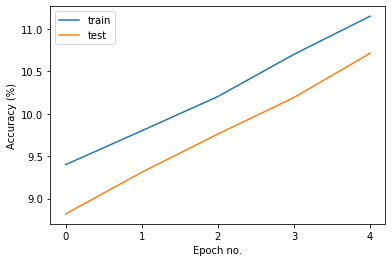

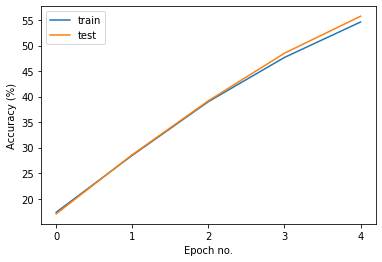

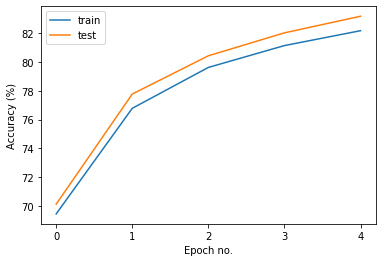

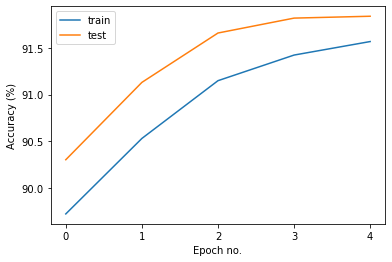

In [14]:
# a) Calculate training and test accuracy at the end of each epoch and the following learning rates
learning_rates = [0.00001, 0.0001, 0.001, 0.1]
for lr in learning_rates:
    model.linear.reset_parameters()
    print(f'Training with learning rate {lr}')
    history = train(lr)
    
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.gca().set_xticks(list(range(0, num_epochs)))

# Write your observation on training and test accuracy with respect to learning rate

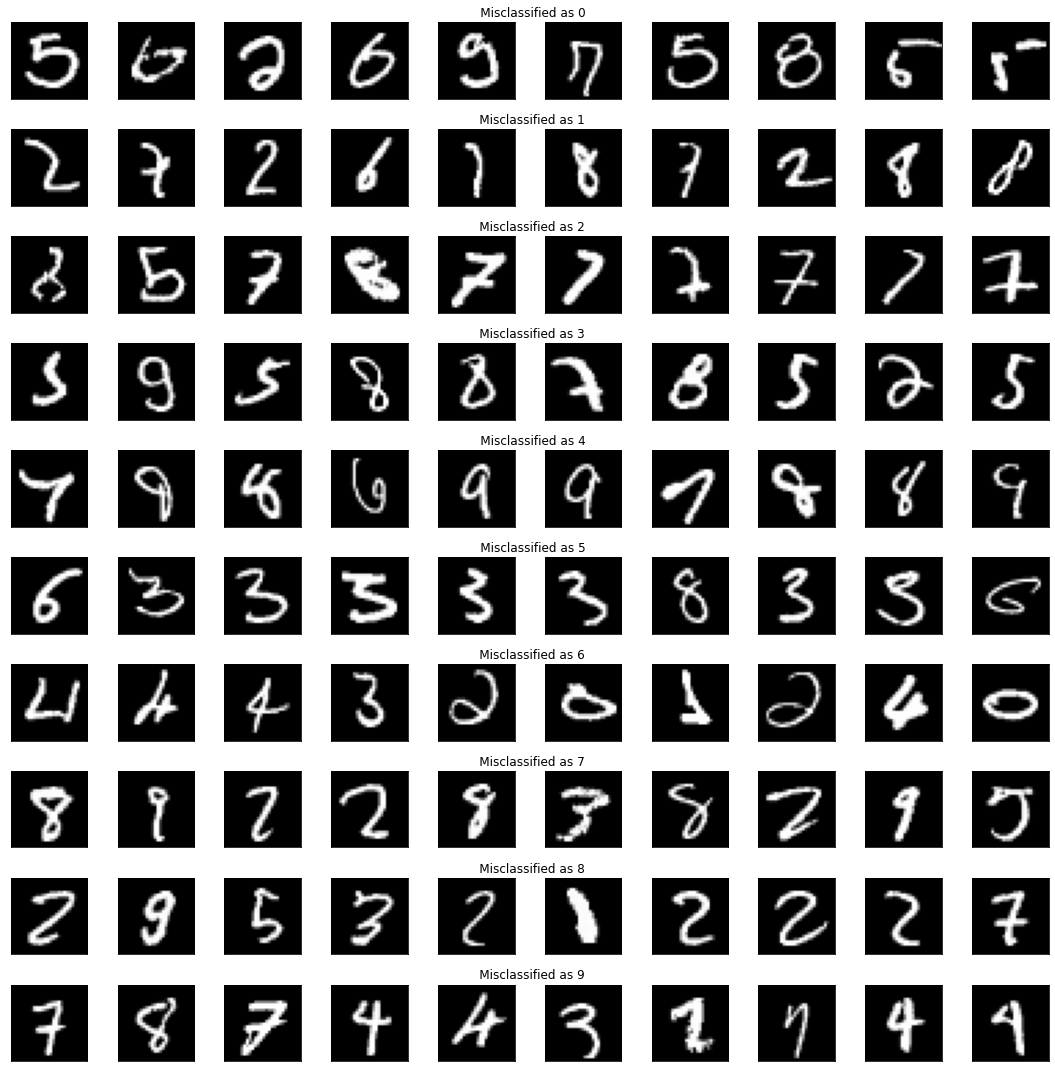

In [15]:
# b) Find 10 misclassified test samples for each output class

misclassified = {k: [] for k in range(10)}
incorrect = []
i = 0
for images, labels in test_loader:
    images = images.view(-1, 28*28)

    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)    
    for pred, act, image in zip(predicted, labels, images):
        if pred != act:
            misclassified[pred.item()].append(image) # save misclassified images





fig=plt.figure(figsize=(15, 15))

for clas in range(10):
    for i in range(1, 11):
        img = misclassified[clas][i].numpy().reshape(28, 28)
        ax = fig.add_subplot(10, 10, clas * 10 + i)
        ax.set_xticks([])
        ax.set_yticks([])
        if i % 5 == 0 and i % 10 != 0:
            ax.set_title(f"                             Misclassified as {clas}")
        plt.imshow(img, cmap='gray')

plt.tight_layout()
plt.show()



# Explanation of misclassification

In [2]:

# c) Classify even-odd
from torchvision.transforms import Lambda

train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1)
                            )
test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor(),
                           target_transform=Lambda(lambda y: 0 if y % 2 == 0 else 1))
input_dim = 28*28
output_dim = 2

model = LogisticRegressionModel(input_dim, output_dim)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)       
history = train(0.01)
history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
plt.gca().set_xticks(list(range(num_epochs)))

NameError: name 'LogisticRegressionModel' is not defined

# Part 3: CNN

In [ ]:
import torchvision
# import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,  transform=transform)


Files already downloaded and verified


In [18]:
class CNNModel(nn.Module):
    def __init__(self, padding, avg_pool=False):
        super(CNNModel, self).__init__()
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=padding)
        self.relu1 = nn.LeakyReLU() # Becaue we want to use leaky relu


        # Max/avg pool, depending on param
        self.pool1 = nn.MaxPool2d(kernel_size=2) if not avg_pool else nn.AvgPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=padding)
        
        # Max/avg pool 2
        self.pool2 = nn.MaxPool2d(kernel_size=2) if not avg_pool else nn.AvgPool2d(kernel_size=2)
        self.relu2 = nn.LeakyReLU() # Becaue we want to use leaky relu

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(8 * 8 * 32 if padding == 2 else 5 * 5 * 32, 10) 

    def forward(self, x):

        # x
        # Convolution 1        
        out = self.cnn1(x)
        out = self.relu1(out)

        
        # Max/avg pool 1
        out = self.pool1(out)

        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max/avg pool 2 
        out = self.pool2(out)

        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)

        return out

In [19]:
# The code we will use to create the models later
# a = CNNModel(2)
# b = CNNModel(2, avg_pool=True)
# c = CNNModel(0)


In [23]:

def train_with_batchsize(model, batch_size):    
    num_epochs = 3

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

    def calc_accuracy(train=False): # add train param to calculate accuracy on both train and test
        # Calculate Accuracy         
        correct = 0
        total = 0
        
        d_loader = train_loader if train else test_loader
        # Iterate through test dataset
        for images, labels in d_loader:
            # Load images
            images = images.requires_grad_()

            # Forward pass only to get logits/output
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()

        return 100 * correct / total

    def train(): # make into train function
        optimizer = torch.optim.SGD(model.parameters(), lr=.01)  
        accuracy = {'train': [], 'test': []} # keep track of accuracies

        for epoch in range(num_epochs):    
            for i, (images, labels) in enumerate(train_loader): # One epoch = 600 iterations or (train_dataset / batch_size)
                # This will load batch_size amount of samples
                images = images.requires_grad_()

                # Clear gradients w.r.t. parameters
                optimizer.zero_grad()

                # Forward pass to get output/logits
                outputs = model(images)

                # Calculate Loss: softmax --> cross entropy loss
                loss = criterion(outputs, labels)

                # Getting gradients w.r.t. parameters
                loss.backward()

                # Updating parameters
                optimizer.step()

            train_accuracy = calc_accuracy(train=True) # abstract accuracy function away
            test_accuracy = calc_accuracy() # abstract accuracy function away
            # Print Loss
            print('Epoch: {} Loss: {}. Train Accuracy: {}, Test Accuracy: {}'.format(epoch, loss.item(), train_accuracy, test_accuracy))

            accuracy['train'].append(train_accuracy.item())
            accuracy['test'].append(test_accuracy.item())
            
        return pd.DataFrame(accuracy)
    
    return train()


Epoch: 0 Loss: 1.1921966075897217. Train Accuracy: 59.16400146484375, Test Accuracy: 57.40999984741211
Epoch: 1 Loss: 0.9606745839118958. Train Accuracy: 66.02799987792969, Test Accuracy: 64.2699966430664
Epoch: 2 Loss: 0.43347302079200745. Train Accuracy: 68.58999633789062, Test Accuracy: 65.69000244140625


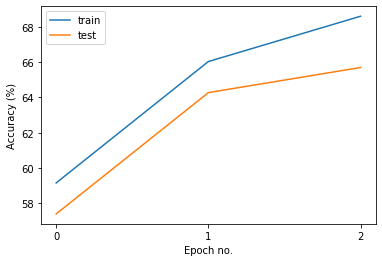

In [29]:
# Model a
batch_sizes = [10, 25, 50]

a_group = []
for sz in batch_sizes:
    model = CNNModel(2)    
    history = train_with_batchsize(model, sz)
    a_group.append(model)
    
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.gca().set_xticks(list(range(0, 3)))
    break

In [ ]:
# Model b
batch_sizes = [10, 25, 50]

b_group = []
for sz in batch_sizes:
    model = CNNModel(2, avg_pool=True)
    history = train_with_batchsize(model, sz)
    
    b_group.append(model)
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.gca().set_xticks(list(range(0, 3)))

In [ ]:
# Model c
batch_sizes = [10, 25, 50]

c_group = []
for sz in batch_sizes:
    model = CNNModel(0)
    history = train_with_batchsize(model, sz)
    
    c_group.append(model)
    history.plot(y=['train', 'test'], use_index=True, xlabel='Epoch no.', ylabel='Accuracy (%)')    
    plt.gca().set_xticks(list(range(0, 3)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-0.40392154  0.33333337  0.7882353 ]
[0.92941177 0.92941177 0.92941177]
[0.13725495 0.36470592 0.6627451 ]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.6627451 0.7411765 0.8117647]
[0.5372549 0.6       0.5764706]
[0.77254903 0.7254902  0.81960785]
[-0.8745098 -0.9137255 -0.9764706]
[-0.9607843 -0.9607843 -0.9607843]
[0.22352946 0.24705887 0.3176471 ]
[-0.11372548  0.15294123  0.30196083]


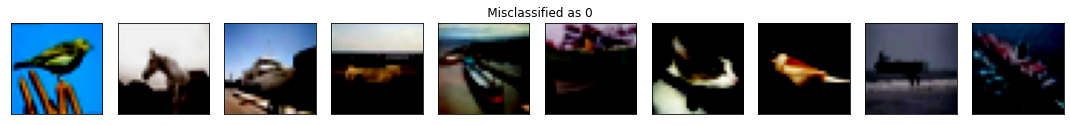

In [43]:
# b) Find 10 misclassified test samples for each output class


test_loader = torch.utils.data.DataLoader(testset, batch_size=10,
                                        shuffle=False, num_workers=2)

best_model = a_group[0]
misclassified = {k: [] for k in range(10)}
incorrect = []
i = 0
for images, labels in test_loader:

    outputs = best_model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)    
    for pred, act, image in zip(predicted, labels, images):
        if pred != act:
            misclassified[pred.item()].append(image) # save misclassified images

fig=plt.figure(figsize=(15, 15))

for clas in range(1):
    for i in range(1, 11):
        img = misclassified[clas][i].numpy()
        img = np.dstack((img[0], img[1], img[2]))
        print(img[0][0])
        ax = fig.add_subplot(10, 10, clas * 10 + i)
        ax.set_xticks([])
        ax.set_yticks([])
        if i % 5 == 0 and i % 10 != 0:
            ax.set_title(f"                             Misclassified as {clas}")
        plt.imshow(img)

plt.tight_layout()
plt.show()




In [50]:
inv_normalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[2, 2, 2]
)

inv_normalize(trainset[0][0])

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.